# 1. 과제 개요

과제는 UNet, UNet++ 중에서 하나를 선택하고 PyTorch로 만들기입니다.

# 2. 과제 출제 목적 및 배경

대회의 베이스라인 코드의 흐름을 익히고, 강의에서 배운 모델들을 하나씩 스스로 만들어보면서 파이토치와 모델 코드 작성에 대한 실력을 기르는 것이 목표입니다.


# 3. 과제 수행으로 얻어갈 수 있는 역량

UNet, UNet++ 모델에 대한 이해와 대회 베이스라인 코드에 대한 이해를 하실 수 있습니다.

# Required Package

```
opencv-python-headless==4.10.0.84
pandas==2.2.3
scikit-learn==1.5.2
albumentations==1.4.18
matplotlib==3.9.2
```

# Table of Contents

1. [Imports & Global Constants](#Imports-&-Global-Constants)
2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset)
3. [Define Dataset Class](#Define-Dataset-Class)
4. [Check Data Sample](#Check-Data-Sample)
5. [Setup Dataloader](#Setup-Dataloader)
6. [Define Functions for Training](#Define-Functions-for-Training)
7. [Define the Model and Train](#Define-the-Model-and-Train)
8. [Inference](#Inference)
9. [Result Visualization](#Result-Visualization)
10. [To CSV](#To-CSV)

# Imports & Global Constants

In [88]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

In [89]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/data/ephemeral/home/MCG/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/MCG/data/train/outputs_json"

In [90]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [91]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [92]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [93]:
BATCH_SIZE = 2
RANDOM_SEED = 21

# 적절하게 조절
NUM_EPOCHS =30
VAL_EVERY = 1
IMSIZE=512
LR = 0.0003
MILESTONES=[8,15,22,26]
GAMMA=0.3

SAVED_DIR = "/data/ephemeral/home/MCG/UNetRefactored/Creadted_model"
MODELNAME="best_HybridLoss.pt"
if not os.path.isdir(SAVED_DIR):
    os.mkdir(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [94]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [95]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [96]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [97]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [98]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [99]:
pngs = sorted(pngs)
jsons = sorted(jsons)

In [100]:
pngs = np.array(pngs)
jsons = np.array(jsons)

# Define Dataset Class

In [101]:
class XRayDataset(Dataset):
    def __init__(self, filenames, labelnames, transforms=None, is_train=False):
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = image / 255.

        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)

        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)

        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label

        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)

            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()

        return image, label

In [102]:
# split train-valid
# 한 폴더 안에 한 인물의 양손에 대한 `.png` 파일이 존재하기 때문에
# 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
# 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
groups = [os.path.dirname(fname) for fname in pngs]

# dummy label
ys = [0 for fname in pngs]

# 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
# 5으로 설정하여 GroupKFold를 수행합니다.
gkf = GroupKFold(n_splits=5)

train_filenames = []
train_labelnames = []
valid_filenames = []
valid_labelnames = []
for i, (x, y) in enumerate(gkf.split(pngs, ys, groups)):
    # 0번을 validation dataset으로 사용합니다.
    if i == 0:
        valid_filenames += list(pngs[y])
        valid_labelnames += list(jsons[y])

    else:
        train_filenames += list(pngs[y])
        train_labelnames += list(jsons[y])

# Check Data Sample

In [103]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)

    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]

    return image

In [104]:
tf = A.Resize(IMSIZE,IMSIZE)



In [105]:
train_dataset = XRayDataset(train_filenames, train_labelnames, transforms=tf, is_train=True)
valid_dataset = XRayDataset(valid_filenames, valid_labelnames, transforms=tf, is_train=False)

In [106]:
image, label = train_dataset[0]

In [107]:
print(image.shape, label.shape)

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])


In [108]:
len(train_dataset)

640

In [109]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#ax[0].imshow(image[0])    # remove channel dimension
#ax[1].imshow(label2rgb(label))

#plt.show()

# Setup Dataloader

In [110]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    drop_last=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

# Define Functions for Training

In [111]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)

    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [112]:
def save_model(model, file_name=MODELNAME):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [113]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [114]:
  
    
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.cuda()
    model.eval()

    dices = []
    total_loss = 0
    cnt = 0

    with torch.no_grad():
        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()

            # 모델 예측
            outputs = model(images)

            # 출력 크기 보정 (필요한 경우만)
            if outputs.shape[-2:] != masks.shape[-2:]:
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

            # 손실 계산
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            cnt += 1

            # 출력 이진화 및 Dice 계산 (GPU 상에서 처리)
            outputs = (torch.sigmoid(outputs) > thr).float()
            dice = dice_coef(outputs, masks)
            dices.append(dice.detach())  # GPU에서 유지

    # GPU 상에서 Dice 평균 계산
    dices = torch.cat(dices, 0)
    dices_per_class = dices.mean(dim=0)
    
    # 로그 출력
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)

    avg_dice = dices_per_class.mean().item()

    return avg_dice


In [115]:
import datetime

def train(model, data_loader, val_loader, criterion, optimizer,scheduler):
    print(f'Start training..')
    model.cuda()

    n_class = len(CLASSES)
    best_dice = 0.

    # 손실 가중치 (Deep Supervision)
    deep_sup_weights = [0.4, 0.4, 0.2, 0.1, 0.1]  # 각 출력에 대한 가중치

    # 스케줄러 추가 (선택적)

    for epoch in range(NUM_EPOCHS):
        # 에폭 시작 시간 기록
        start_time = datetime.datetime.now()
        print(f"Epoch {epoch + 1} started at {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

        model.train()

        for step, (images, masks) in enumerate(data_loader):
            # GPU 연산을 위해 device 할당
            images, masks = images.cuda(), masks.cuda()

            # Inference
            outputs = model(images)

            # Deep Supervision 처리: 여러 출력을 가정
            if isinstance(outputs, (tuple, list)):  # 출력이 리스트/튜플 형태인 경우
                total_loss = 0.0
                for i, output in enumerate(outputs):
                    loss = criterion(output, masks)  # 각 출력의 손실 계산
                    total_loss += deep_sup_weights[i] * loss  # 가중치를 곱해 합산
            else:  # 출력이 단일 텐서인 경우 (예외 처리)
                total_loss = criterion(outputs, masks)

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Step 주기에 따른 손실 출력
            if (step + 1) % 80 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(data_loader)}], '
                    f'Loss: {round(total_loss.item(), 4)}'
                )

        # Validation 주기에 따른 Loss 출력 및 Best Model 저장
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)

            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)

        # 스케줄러 업데이트
        scheduler.step()
        print(f"Epoch {epoch + 1}: Learning Rate -> {scheduler.get_last_lr()}")

        # 에폭 종료 시간 기록
        end_time = datetime.datetime.now()
        print(f"Epoch {epoch + 1} ended at {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Epoch {epoch + 1} duration: {str(end_time - start_time)}")


# Define the Model and Train

![image.png](http://drive.google.com/uc?export=view&id=1CQRLAiLVbNFXs5iHUzYWcYZBt83xfgWr)

In [116]:
import torch.nn as nn
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


In [117]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

In [118]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetEncoder(nn.Module):
    def __init__(self, in_channels=3, pretrained=True):
        super(ResNetEncoder, self).__init__()
        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT if pretrained else None)
        
        # 입력 채널 변경
        if in_channels != 3:
            self.input_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.input_conv.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True).repeat(1, in_channels, 1, 1)
        else:
            self.input_conv = resnet.conv1

        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1  # ResNet block 1
        self.layer2 = resnet.layer2  # ResNet block 2
        self.layer3 = resnet.layer3  # ResNet block 3
        self.layer4 = resnet.layer4  # ResNet block 4

    def forward(self, x):
        h1 = self.relu(self.bn1(self.input_conv(x)))  # h1: 64 channels
        h2 = self.layer1(self.maxpool(h1))           # h2: 256 channels
        h3 = self.layer2(h2)                         # h3: 512 channels
        h4 = self.layer3(h3)                         # h4: 1024 channels
        h5 = self.layer4(h4)                         # h5: 2048 channels
        return h1, h2, h3, h4, h5


In [119]:
class UNet_3Plus_DeepSup(nn.Module):
    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet_3Plus_DeepSup, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 256, 512, 1024, 2048] #백본 Output이랑 맞춰서 지정

        ## -------------Encoder--------------
        self.encoder = ResNetEncoder(in_channels=in_channels)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # -------------Bilinear Upsampling--------------
        self.upscore5 = nn.Upsample(size=(IMSIZE, IMSIZE), mode='bilinear', align_corners=True)  # 512x512로 고정
        self.upscore4 = nn.Upsample(size=(IMSIZE, IMSIZE), mode='bilinear', align_corners=True)  # 512x512로 고정
        self.upscore3 = nn.Upsample(size=(IMSIZE, IMSIZE), mode='bilinear', align_corners=True)  # 512x512로 고정
        self.upscore2 = nn.Upsample(size=(IMSIZE, IMSIZE), mode='bilinear', align_corners=True)  # 512x512로 고정
        self.upscore1 = nn.Upsample(size=(IMSIZE, IMSIZE), mode='bilinear', align_corners=True)  # 512x512로 고정

        # DeepSup
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv2 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv3 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv4 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)
        self.outconv5 = nn.Conv2d(filters[4], n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1, h2, h3, h4, hd5 = self.encoder(inputs)  # ResNet이 반환한 feature maps


        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d5 = self.outconv5(hd5)
        d5 = self.upscore5(d5) # 16->256

        d4 = self.outconv4(hd4)
        d4 = self.upscore4(d4) # 32->256

        d3 = self.outconv3(hd3)
        d3 = self.upscore3(d3) # 64->256

        d2 = self.outconv2(hd2)
        d2 = self.upscore2(d2) # 128->256

        d1 = self.outconv1(hd1) # 256
        d1 = self.upscore1(d1)
        

        if self.training:
            return d1, d2, d3, d4, d5
        else:
            return d1

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import exp


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    if val_range is None:
        L = 1  # Assuming normalized images in [0, 1]

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret


def msssim(img1, img2, window_size=11, size_average=True, normalize=False):
    device = img1.device
    weights = torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).to(device)
    levels = weights.size()[0]
    mssim = []
    mcs = []
    for _ in range(levels):
        sim, cs = ssim(img1, img2, window_size=window_size, size_average=size_average, full=True)
        mssim.append(sim)
        mcs.append(cs)

        img1 = F.avg_pool2d(img1, (2, 2))
        img2 = F.avg_pool2d(img2, (2, 2))

    mssim = torch.stack(mssim)
    mcs = torch.stack(mcs)

    if normalize:
        mssim = (mssim + 1) / 2
        mcs = (mcs + 1) / 2

    pow1 = mcs ** weights
    pow2 = mssim ** weights
    output = torch.prod(pow1[:-1] * pow2[-1])
    return output


class MSSSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, channel=3):
        super(MSSSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = channel

    def forward(self, img1, img2):
        return msssim(img1, img2, window_size=self.window_size, size_average=self.size_average, normalize=True)


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.3, gamma=0.2, smooth=1e-6):
        """
        Combined Loss = alpha * Focal Loss + beta * IoU Loss + gamma * MS-SSIM Loss
        """
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth
        self.ms_ssim = MSSSIM(window_size=11, size_average=True, channel=1)

    def focal_loss(self, logits, targets, alpha=0.8, gamma=2.0):
        probs = torch.sigmoid(logits)
        focal_loss = -alpha * (1 - probs) ** gamma * targets * torch.log(probs + 1e-6) \
                     - (1 - alpha) * probs ** gamma * (1 - targets) * torch.log(1 - probs + 1e-6)
        return focal_loss.mean()

    def iou_loss(self, logits, targets):
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) - intersection
        iou_loss = 1 - (intersection + self.smooth) / (union + self.smooth)
        return iou_loss.mean()

    def forward(self, logits, targets):
        focal = self.focal_loss(logits, targets)
        iou = self.iou_loss(logits, targets)
        ms_ssim_loss = 1 - self.ms_ssim(torch.sigmoid(logits), targets)

        total_loss = self.alpha * focal + self.beta * iou + self.gamma * ms_ssim_loss
        return total_loss


In [121]:
model = UNet_3Plus_DeepSup(n_classes=len(CLASSES))



In [122]:


# Loss function 정의
criterion = CombinedLoss(alpha=1, beta=1, gamma=1)
#criterion = nn.BCEWithLogitsLoss()


LR = 0.00099
MILESTONES=[6,16,23,27]
GAMMA=0.3

# Optimizer 정의
optimizer = optim.Adam(params=model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)




In [123]:
set_seed()

In [124]:
#train(model, train_loader, valid_loader, criterion, optimizer,scheduler)

# Inference

In [125]:
model = torch.load(os.path.join(SAVED_DIR, "best_NewModel.pt"))

In [126]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/data/ephemeral/home/MCG/data/test/DCM"

In [127]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [128]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask
    1 - mask
    0 - background
    Returns encoded run length
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [129]:
def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(height, width)

In [130]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))

        self.filenames = _filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = image / 255.

        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first

        image = torch.from_numpy(image).float()

        return image, image_name

In [131]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()
            outputs = model(images)

            # restore original size
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()

            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")

    return rles, filename_and_class

In [132]:
tf = A.Resize(512, 512)

In [133]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [134]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [135]:
rles, filename_and_class = test(model, test_loader)

100%|██████████| 144/144 [02:34<00:00,  1.08s/it]


# Result Visualization

In [136]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [137]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [138]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

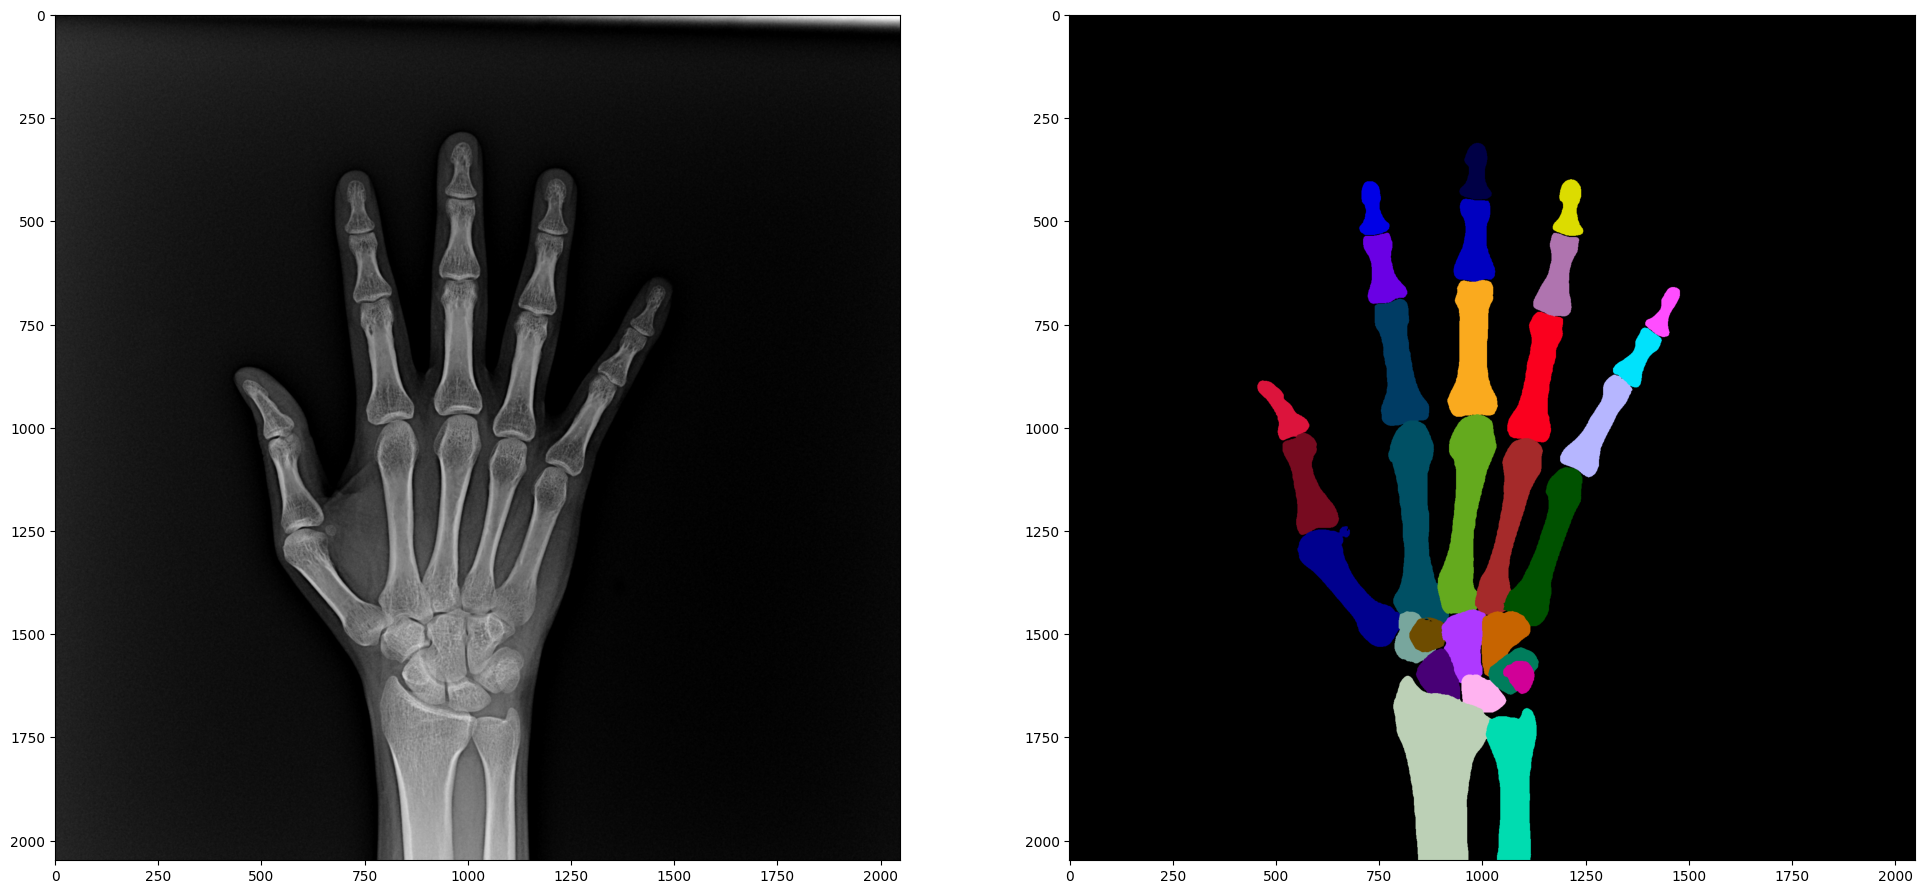

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

# To CSV

In [140]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [141]:
image_name = [os.path.basename(f) for f in filename]

In [142]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [143]:
df.head(30)

,image_name,class,rle
0,image1661319116107.png,finger-1,1817044 4 1819089 16 1821135 22 1823182 26 182...
1,image1661319116107.png,finger-2,2077237 9 2079283 13 2081329 18 2083374 23 208...
2,image1661319116107.png,finger-3,2540188 7 2542231 13 2544278 14 2546325 15 254...
3,image1661319116107.png,finger-4,830162 15 832208 19 834254 23 836301 26 838348...
4,image1661319116107.png,finger-5,1084162 2 1086207 8 1088252 12 1090294 19 1092...
5,image1661319116107.png,finger-6,1411872 4 1413916 12 1415962 17 1418007 22 142...
6,image1661319116107.png,finger-7,2016057 19 2018101 25 2020147 29 2022192 35 20...
7,image1661319116107.png,finger-8,639962 8 642006 16 644052 20 646098 24 648145 ...
8,image1661319116107.png,finger-9,916415 6 918459 19 920506 25 922553 29 924600 ...
9,image1661319116107.png,finger-10,1319911 9 1321914 6 1321954 20 1323959 13 1323...


In [144]:
df.to_csv("NewModel.csv", index=False)

In [77]:
len(df)

8352

In [78]:
df["image_name"].nunique()

288

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

# 클래스 정의 (이전에 작성한 코드 그대로 복사)
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(
                    nn.Conv2d(in_size, out_size, ks, s, p),
                    nn.BatchNorm2d(out_size),
                    nn.ReLU(inplace=True),
                )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size
        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(
                    nn.Conv2d(in_size, out_size, ks, s, p),
                    nn.ReLU(inplace=True),
                )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)
        return x


class UNet_3Plus_DeepSup(nn.Module):
    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True, pretrained=True):
        super(UNet_3Plus_DeepSup, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale
        self.resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT if pretrained else None)

        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        #self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        #self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        #self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        self.conv4 = self.resnet.layer2

        self.conv5 = self.resnet.layer3

    def forward(self, inputs):
        ## -------------Encoder-------------
        
        
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.conv4(h3)
        hd5 = self.conv5(h4)  # h5->20*20*1024
        
        print(f"h1 shape: {h1.shape}")

        print(f"h2 shape: {h2.shape}")

        print(f"h3 shape: {h3.shape}")
        print(f"h4 shape: {h4.shape}")
        print(f"hd5 shape: {hd5.shape}")
        

        return hd5


# 테스트 입력 생성
model = UNet_3Plus_DeepSup()
test_input = torch.randn(1, 3, 320, 320)  # 배치 크기 1, 채널 3, 이미지 크기 320x320

# 모델 실행
model(test_input)

'''

h1 shape: torch.Size([1, 64, 320, 320])
h2 shape: torch.Size([1, 128, 160, 160])
h3 shape: torch.Size([1, 256, 80, 80])
h4 shape: torch.Size([1, 512, 40, 40])
h5 shape: torch.Size([1, 512, 20, 20])
hd5 shape: torch.Size([1, 1024, 20, 20])
'''


h1 shape: torch.Size([1, 64, 320, 320])
h2 shape: torch.Size([1, 128, 160, 160])
h3 shape: torch.Size([1, 256, 80, 80])
h4 shape: torch.Size([1, 512, 40, 40])
hd5 shape: torch.Size([1, 1024, 20, 20])


'\n\nh1 shape: torch.Size([1, 64, 320, 320])\nh2 shape: torch.Size([1, 128, 160, 160])\nh3 shape: torch.Size([1, 256, 80, 80])\nh4 shape: torch.Size([1, 512, 40, 40])\nh5 shape: torch.Size([1, 512, 20, 20])\nhd5 shape: torch.Size([1, 1024, 20, 20])\n'

### **콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

### **데이터셋 저작권**

<font color='red'><b>**WARNING**</b></font> : 캠프 교육용 라이선스 (대외 노출 금지)